![alt text](path_to_banner_image.jpg)
# Title
Author: Elijah Lopez

## Overview


## Business Problem


## Data


### Summary of Data Findings


## Potential Routes of Analysis


## Chosen Metrics for Analysis


## Data Cleaning & Feature Engineering

## Analysis

### Direction 1


#### Direction 1 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 1:

### Direction 2


#### Direction 2 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 2:

### Direction 3

#### Direction 3 Statistical Testing
Rationale for test selection
H0:
H1:

Recommendation 3:

## Results


### Direction 1
* 


### Direction 2
* 


### Direction 3
* 

## Conclusions
This analysis leads to three recommendations.

1. 

2. 

3. 

## Next Steps
* 

## Resources
* [QQQ](https://www.invesco.com/qqq-etf/en/performance.html) - ETF Tracked
* [Yahoo Finance](https://finance.yahoo.com/) - Stock-related data
* [Federal Reserve Economic Data](https://fred.stlouisfed.org/) - Economic-related data
* [Bureau of Economic Analysis](https://www.bea.gov/)

In [88]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns
import category_encoders as ce

# Inferential Statistical Tests
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway, pearsonr
from scipy.stats import zscore, norm, binom, poisson
from statsmodels.stats.proportion import proportions_ztest

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [89]:
import yfinance as yf

# Fetch the data
ticker = 'QQQ'
stock_data = yf.download(ticker, start='2000-01-01', end='2022-12-31')

# Reset index and set 'Date' as the new index
stock_data.reset_index(inplace=True)
stock_data.set_index('Date', inplace=True)

# Flatten columns by removing the 'Ticker' level (second level of the MultiIndex)
stock_data.columns = stock_data.columns.get_level_values(0)  # Get the first level, which contains the price types

# Select the relevant columns
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Remove 'Price' column label
stock_data.columns.name = None

# Display the first few rows
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563774,36345200
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036980,33786600
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123848,42496600
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101875,37134800
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524948,28138200


In [90]:
stock_data.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
stock_data.columns = stock_data.columns.str.lower()
stock_data.head()

,open,high,low,close,adj_close,volume
Date,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563774,36345200
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036980,33786600
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123848,42496600
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101875,37134800
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524948,28138200


In [91]:
stock_data.index.name = stock_data.index.name.lower()
stock_data.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563774,36345200
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036980,33786600
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123848,42496600
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101875,37134800
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524948,28138200


In [ ]:
from fredapi import Fred
import pandas as pd

# Set up FRED API
fred = Fred(api_key='51f2961dd04afe20a0da350a4454eeb6')

# Define FRED series for required economic indicators
series_ids = {
    'interest_rate': 'DFF',            # Federal Funds Rate (%)
    'gdp_growth': 'A191RL1Q225SBEA',   # Real GDP Growth (% change YOY)
    'inflation_rate': 'FPCPITOTLZGUSA',      # Consumer Price Index (% change YOY)
    'unemployment_rate': 'UNRATE',     # Unemployment Rate (%)
    'consumer_sentiment': 'UMCSENT'    # Consumer Sentiment Index (100 = Q1 1966)
}

# Fetch and consolidate data
data = {}
for key, series_id in series_ids.items():
    data[key] = fred.get_series(series_id)

# Combine into a single DataFrame
economic_data = pd.concat(data, axis=1)
economic_data.index.name = 'date'

economic_data.head()

,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,
1947-04-01,NaN,-1.0,NaN,NaN,NaN
1947-07-01,NaN,-0.8,NaN,NaN,NaN
1947-10-01,NaN,6.4,NaN,NaN,NaN
1948-01-01,NaN,6.2,NaN,3.4,NaN
1948-02-01,NaN,NaN,NaN,3.8,NaN


In [93]:
# Inspect date range for overlapping period of QQQ data to see if
# backfilling is reasonable. Because values are reported regularly during this
# time I chose to continue with approach.
overlapping_economic_data = economic_data.loc['2000-01-01' : '2022-12-31']
# overlapping_economic_data     #Scrolled through entire df but commented out for readability
overlapping_economic_data.head()

,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,
2000-01-01,3.99,1.5,3.376857,4.0,112.0
2000-01-02,3.99,NaN,NaN,NaN,NaN
2000-01-03,5.43,NaN,NaN,NaN,NaN
2000-01-04,5.38,NaN,NaN,NaN,NaN
2000-01-05,5.41,NaN,NaN,NaN,NaN


In [95]:
economic_data.fillna(method='bfill', inplace=True)
economic_data.head()

,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,
1947-04-01,1.13,-1.0,1.457976,3.4,86.2
1947-07-01,1.13,-0.8,1.457976,3.4,86.2
1947-10-01,1.13,6.4,1.457976,3.4,86.2
1948-01-01,1.13,6.2,1.457976,3.4,86.2
1948-02-01,1.13,6.8,1.457976,3.8,86.2


In [98]:
merged_df = stock_data.join(economic_data, how='left', on='date')
merged_df.head()

,open,high,low,close,adj_close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,80.563774,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,88.25000,75.036980,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,86.00000,73.123848,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,80.09375,68.101875,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,90.00000,76.524948,28138200,5.61,7.5,2.826171,4.1,111.3


In [99]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5787 entries, 2000-01-03 to 2022-12-30
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open                5787 non-null   float64
 1   high                5787 non-null   float64
 2   low                 5787 non-null   float64
 3   close               5787 non-null   float64
 4   adj_close           5787 non-null   float64
 5   volume              5787 non-null   int64  
 6   interest_rate       5787 non-null   float64
 7   gdp_growth          5787 non-null   float64
 8   inflation_rate      5787 non-null   float64
 9   unemployment_rate   5787 non-null   float64
 10  consumer_sentiment  5787 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 542.5 KB


In [100]:
merged_df.isna().sum()

open                  0
high                  0
low                   0
close                 0
adj_close             0
volume                0
interest_rate         0
gdp_growth            0
inflation_rate        0
unemployment_rate     0
consumer_sentiment    0
dtype: int64

In [102]:
merged_df.describe()

,open,high,low,close,adj_close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
count,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5.787000e+03,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000
mean,104.532803,105.402486,103.555050,104.524554,98.056671,6.925599e+07,1.644712,2.238327,2.525839,5.858752,83.883359
std,90.942453,91.650603,90.133079,90.947992,90.644342,5.012344e+07,1.869398,5.294044,1.653307,1.968575,12.955685
min,19.940001,20.530001,19.760000,20.059999,17.056557,5.212000e+06,0.040000,-28.100000,-0.355546,3.400000,50.000000
25%,41.099998,41.500000,40.630001,41.085001,35.286629,3.201710e+07,0.130000,1.100000,1.586032,4.400000,74.200000
50%,64.839996,65.309998,64.349998,64.900002,57.665016,5.766340e+07,1.000000,2.500000,2.270095,5.400000,86.100000
75%,131.899994,132.325005,131.480003,131.889999,125.015575,9.158560e+07,2.380000,3.500000,3.225944,6.700000,93.750000
max,405.570007,408.709991,402.579987,403.989990,396.067627,6.167723e+08,7.030000,35.200000,8.002800,14.800000,111.300000


Observations:
* Stock price at open, low of the day, high of the day, closing price, and adjusted close follow the general trend of right skew (mean > median) and a wide range of minimum and maximum prices.
* Volume median is roughly 55M and mean is roughly 67M shares traded per day. Range is from 5.2M to 617M.
* Interest rate over this time period is between 0.04% and 7.03% with positive skew.
* GDP ranges from -28% to 35% (each due to the effects of COVID) with the median at 2.5% growth per year.
* Inflation ranges from -.36% to 8.0% with median and average near 2.5%.
* Unemployment Rate ranges from 3.4-14.8% with mean and median separated by about half a percentage.
* Consumer sentiment in reference to the stable time period from Q1 1966 is significantly down for both the mean and median.

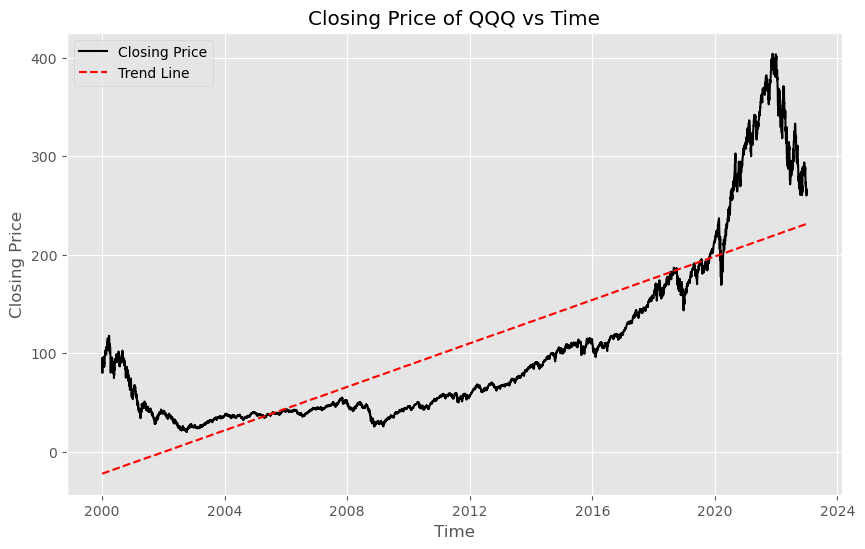

In [104]:
# Graph performance of QQQ over time

# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['close'], label='Closing Price', color='black')

# Fit a linear trend line
x = np.arange(len(stock_data))  # Create an array of from 0 to length of df
y = stock_data['close'].values  # Extract closing prices
trend = np.polyfit(x, y, 1)  # Fit to data
trend_line = np.polyval(trend, x)  # Calculate

# Plot the trend line
plt.plot(stock_data.index, trend_line, label='Trend Line', color='red', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title(f'Closing Price of {ticker} vs Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()